In [2]:
import importlib
import loadData as ld
importlib.reload(ld)
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import collections
import sklearn.decomposition as sk

import metrics
importlib.reload(metrics)

#To display word cloud 
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud

In [3]:
#Commande pour lancer sur Floyd  sudo floyd run --env keras --mode jupyter --cpu --data atarax/datasets/cnn_storiestgz/1:/data

#directory = "data/CNN"
#stories = ld.load_stories(directory)[:10000]

#Pour le l'entrainement sur le cloud
tarDirectory = "../data/cnn_stories.tgz"
stories = ld.load_stories_tgz(tarDirectory)
len(stories)

92579

In [4]:
#Embedding pré-entrainé : conceptNet > Glove 
embeddings_index = {}
with open('../data/numberbatch-en.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

In [5]:
corpus = ""

for document in stories:
    corpus += "_start_ " + ' '.join(ld.del_specialChars(document['story']).split()[:300])
    corpus += "_start_ " + ' '.join(ld.del_specialChars(' '.join(document['highlights'])).split()[:300])

corpus = corpus.lower()
words = corpus.split(' ')

allWords = words
words=list(set(words))


VOCAB_SIZE = len(set(words))

if(VOCAB_SIZE > 40000):
    VOCAB_SIZE = 40000
    words = list(np.array(collections.Counter(allWords).most_common(VOCAB_SIZE))[:, 0])
       

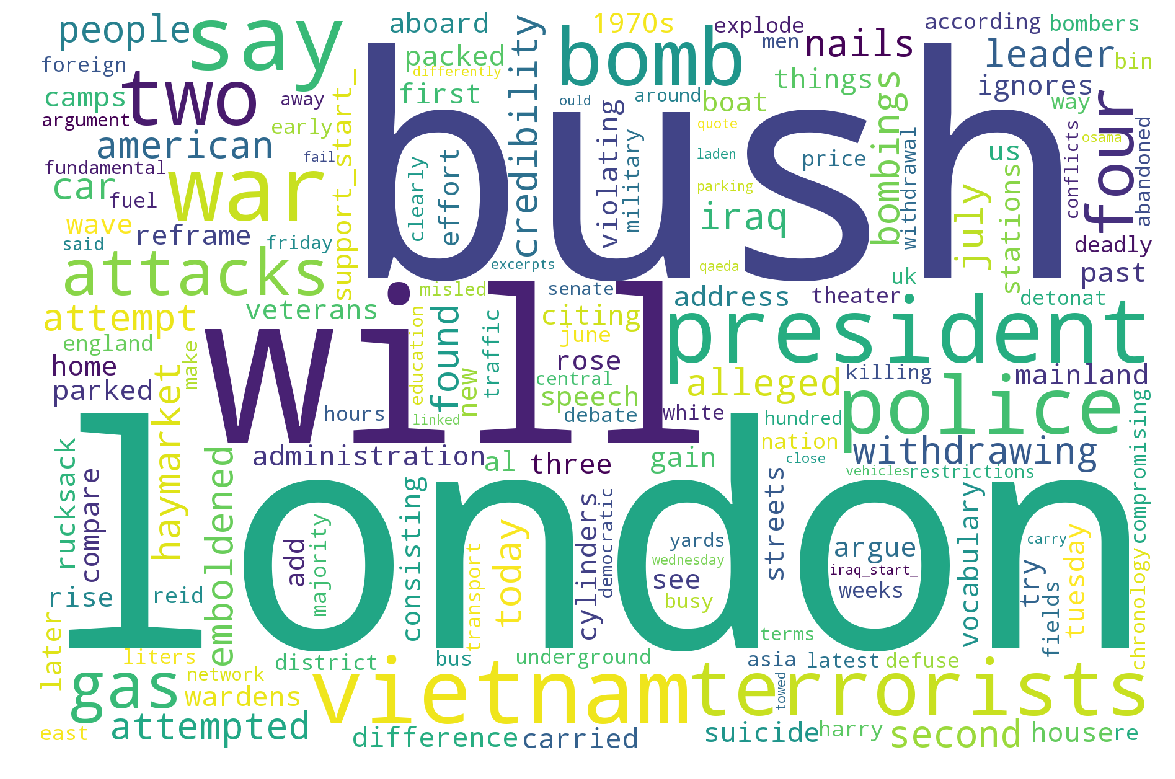

In [6]:
stopWords = set(STOPWORDS)

wc = WordCloud(background_color="white",
                                 max_words=200,
                                 stopwords= stopWords,
                                 width=1800, height=1200)

wc.generate(corpus[20000:22000])

plt.figure(figsize=(20,15))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [7]:
#Recupération des embeddings des mots utilisés 

START_EMBEDDING_DIM = 300
EMBEDDING_DIM = 300

word_embedding_matrix = np.zeros((VOCAB_SIZE, START_EMBEDDING_DIM), 
                                 dtype=np.float32)

dicWords = collections.OrderedDict(zip(words, range(0, VOCAB_SIZE)))

for word, i in dicWords.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, START_EMBEDDING_DIM))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding
        
        
#pca = sk.PCA(n_components=EMBEDDING_DIM)

#word_embedding_matrix = pca.fit_transform(word_embedding_matrix)

np.shape(word_embedding_matrix)

(40000, 300)

In [8]:
#convert x_train and y_train words in index and make padding

x_train = []
y_train = []

print("toto : ", len(list(dicWords)))

for story in stories:    
    newStories = ld.split_articles(story['story'], story['highlights'], 4)

    for newStory in newStories:
        story_x, highlights_x = newStory
        x = ld.convertWordsToIndex(' '.join(ld.del_specialChars(story_x).split()[:300]), dicWords)
        y = ld.convertWordsToIndex(' '.join(ld.del_specialChars(highlights_x).split()[:40]), dicWords)

        x_train.append(np.array(x))
        y_train.append(np.array(y))
    
x_train = pad_sequences(x_train, padding='post')
y_train = pad_sequences(y_train, padding='post')

print("shape x_train : ", np.shape(x_train))
print("shape y_train : ", np.shape(y_train))

toto :  40000
shape x_train :  (441150, 300)
shape y_train :  (441150, 40)


In [9]:
VOCAB_SIZE

40000

In [10]:
#charger le modèle du cloud

from keras.models import load_model
base_model=load_model('../model/model_90000_update.h5')


In [ ]:
#Autre test 

#Ajout
doc_length = np.shape(x_train)[1]

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, BatchNormalization
from keras import optimizers

#arbitrarly set latent dimension for embedding and hidden units
latent_dim = EMBEDDING_DIM

##### Define Model Architecture ######

########################
#### Encoder Model ####
encoder_inputs = Input(shape=(doc_length,), name='Encoder-Input', mask_zero=True)

# Word embeding for encoder (ex: Issue Body)
x = Embedding(VOCAB_SIZE, 
              EMBEDDING_DIM, 
              name='Body-Word-Embedding', 
              weights=[word_embedding_matrix],
              trainable=False,
              mask_zero=True)(encoder_inputs)

x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# We do not need the `encoder_output` just the hidden state.
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-GRU')(x)


encoder_model = Model(inputs=encoder_inputs, 
                      outputs=state_h, 
                      name='Encoder-Model')

seq2seq_encoder_out = encoder_model(encoder_inputs)

########################
#### Decoder Model ####
decoder_inputs = Input(shape=(None,), name='Decoder-Input', mask_zero=True)  # for teacher forcing

# Word Embedding For Decoder (ex: Issue Titles)
dec_emb = Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    name='Decoder-Word-Embedding',
                    weights=[word_embedding_matrix],
                    trainable=False,
                    mask_zero=True)(decoder_inputs)

dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(latent_dim, 
                  return_state=True, 
                  return_sequences=True, 
                  name='Decoder-GRU')

decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(VOCAB_SIZE, 
                      activation='softmax', 
                      name='Final-Output-Dense')

decoder_outputs = decoder_dense(x)


# Seq2Seq Model

#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), 
loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
seq2seq_Model.summary()


In [2]:
# training
batch_size = 128
epochs = 5
history = seq2seq_Model.fit([x_train, y_train[:, :-1]], np.expand_dims(y_train[:, 1:], -1),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, validation_split=0.12)

NameError: name 'y_train' is not defined

In [11]:
import utils as utl

importlib.reload(utl)

seq2seq_inf = utl.Seq2Seq_Inference(encoder_preprocessor=x_train,
                                 decoder_preprocessor=y_train,
                                 seq2seq_model=base_model,
                                 words2idx=dicWords,
                                 idx2words=words)

articleIdx=20

test = list(x_train[articleIdx])

#print(stories[articleIdx])

print("Vrai résumé : ", ld.convertIndexToWords(y_train[articleIdx], words))
print()

seq2seq_inf.demo_model_predictions(np.array(test))   



Vrai résumé :  _start_ new: nfl chief atlanta falcons owner critical of michael vick s conduct nfl suspends falcons quarterback indefinitely without pay vick admits funding dogfighting operation but says he did not gamble vick due in federal court monday; future in nfl



's return to the bynes show he says he s not going to be a errant says he ll be looking for a new jersey sunglasses says he s not'

In [13]:
#Evaluate the model

print(metrics.evaluate_supervised_model(seq2seq_inf, x_train, y_train, 3000, words))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Done !
{'rouge-2': {'p': 0.009620372888830385, 'f': 0.01137973358672059, 'r': 0.015304221108526202}, 'rouge-1': {'p': 0.11661399983088604, 'f': 0.13967573222212132, 'r': 0.1845161448389033}, 'rouge-l': {'p': 0.08642516619849712, 'f': 0.09429821248069169, 'r': 0.1385816179683676}}


In [17]:
import utils as utl

importlib.reload(utl)

seq2seq_inf = utl.Seq2Seq_Inference(encoder_preprocessor=x_train,
                                 decoder_preprocessor=y_train,
                                 seq2seq_model=base_model,
                                 words2idx=dicWords,
                                 idx2words=words)

articleIdx=31295

test = list(x_train[articleIdx])

#print(stories[articleIdx])

print("Vrai résumé : ", ld.convertIndexToWords(y_train[articleIdx], words))
print()

corpusSplit = []

i=0
for x in x_train[20000:22000]:
    if( i%100 == 0):
        print(i)

    corpusSplit.append(seq2seq_inf.demo_model_predictions(np.array(x)))   
    i+=1

generatedCorpus = ' '.join(corpusSplit)

Vrai résumé :  _start_ joan rivers wins this season s celebrity apprentice rivers goes up against poker champion annie duke in finale duke raises more money at her event but rivers is able to attract more celebrities the victory means $250000 for rivers

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


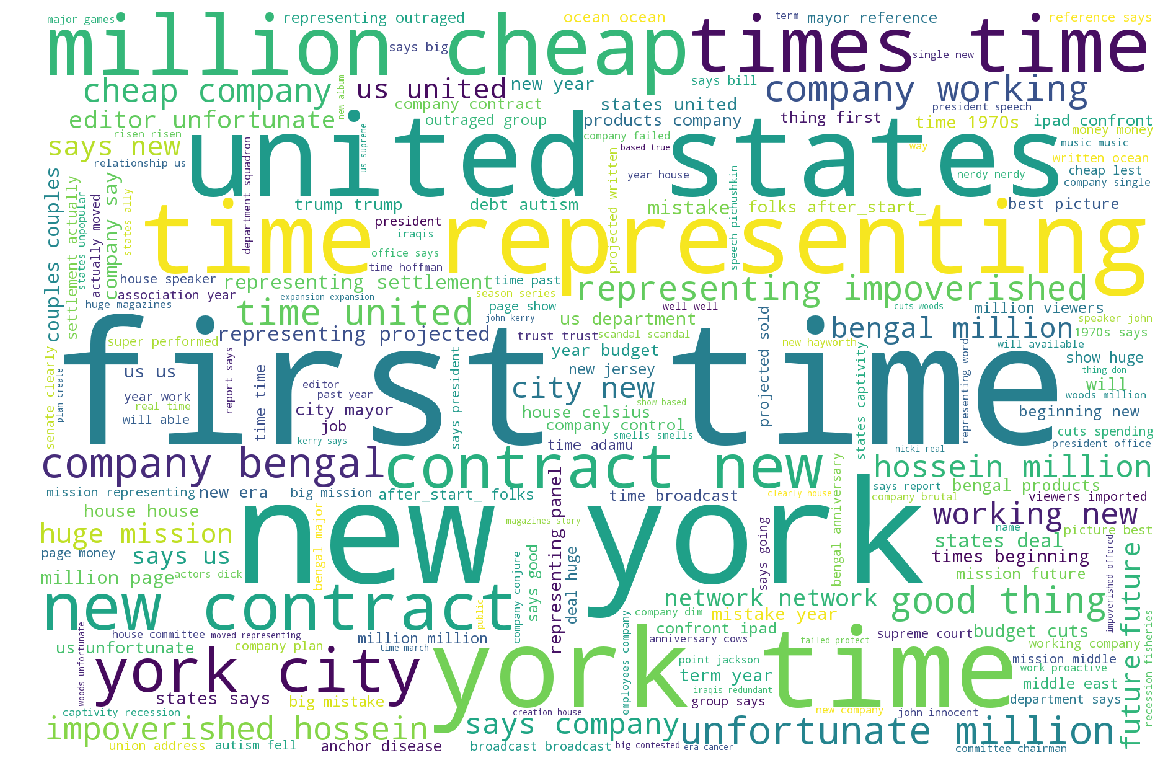

In [18]:
wc.generate(generatedCorpus)

plt.figure(figsize=(20,15))
plt.imshow(wc)
plt.axis("off")
plt.show()
